In [1]:
import util
import argparse
from model import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from argparse import Namespace

args = Namespace(addaptadj=True, adjdata='data/adj_mat/adj_mx_full.pkl', adjtype='transition', aptonly=False, batch_size=15, data='data/DRB_30_10', device='cuda', dropout=0.3, epochs=70, epochs_pre=30, expid='full_30_10Rmse', gcn_bool=True, kernel_size=4, layer_size=2, learning_rate=0.001, n_blocks=4, nhid=32, num_nodes=456, obs_flow_file='../river-dl/data/in/obs_flow_full', obs_temper_file='../river-dl/data/in/obs_temp_full', offset=0.1, out_dim=3, pretrain_file='../river-dl/data/in/uncal_sntemp_input_output', primary_variable='temp', print_every=10, randomadj=False, seq_length=30, test_end_date=['1985-09-30', '2021-09-30'], test_start_date=['1980-10-01', '2020-10-01'], train_end_date=['2006-09-30', '2020-09-30'], train_start_date=['1985-10-01', '2016-10-01'], val_end_date='2016-09-30', val_start_date='2006-10-01', weight_decay=0.0001, x_vars=['seg_rain', 'seg_tave_air', 'seginc_swrad', 'seg_length', 'seginc_potet', 'seg_slope', 'seg_humid', 'seg_elev', 'seg_upstream_inflow', 'seginc_sroff'], y_vars=['seg_tave_water'])
args.checkpoint = './data/DRB_30_10/train_val_drb/full_30_10Rmse_best_1.63.pth'
args.device = 'cpu'


model load successfully
torch.Size([599, 456, 3])


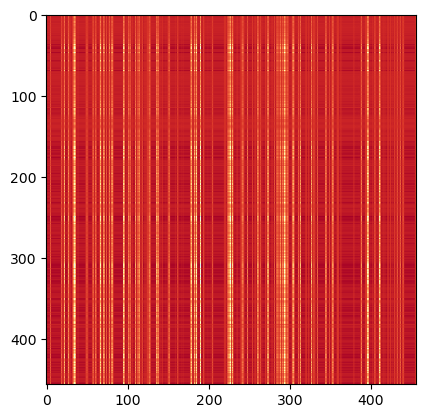

torch.Size([599, 456, 3])


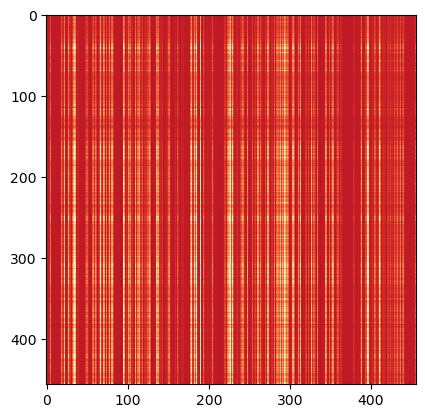

In [2]:
device = torch.device(args.device)

_, _, adj_mx = util.load_adj(args.adjdata,args.adjtype)
supports = [torch.tensor(adj_mx).to(device).float()]
args.in_dim = len(args.x_vars)

if args.randomadj:
    adjinit = None
else:
    adjinit = supports[0]

if args.aptonly:
    supports = None

model = gwnet(device, args.num_nodes, args.dropout, supports=supports, gcn_bool=args.gcn_bool, addaptadj=args.addaptadj,
               in_dim=args.in_dim, out_dim=args.out_dim, residual_channels=args.nhid, dilation_channels=args.nhid,
              skip_channels=args.nhid * 8, end_channels=args.nhid * 16, aptinit=adjinit, kernel_size=args.kernel_size, layers=args.layer_size)

#model =  gwnet(device, args.num_nodes, args.dropout, supports=supports, gcn_bool=args.gcn_bool, addaptadj=args.addaptadj, aptinit=adjinit)
model.to(device)
#dict = torch.load(args.checkpoint, map_location=torch.device('cpu'))
model.load_state_dict(torch.load(args.checkpoint, map_location=torch.device('cpu')))
model.eval()
print('model load successfully')

dataloader = util.load_dataset(args.data, args.batch_size, args.batch_size, args.batch_size)
scaler = dataloader['scaler']
outputs = []
realy = torch.Tensor(dataloader['y_test']).to(device)
realy = realy.transpose(1,3)[:,0,:,:]

for iter, (x, y) in enumerate(dataloader['test_loader'].get_iterator()):
    testx = torch.Tensor(x).to(device)
    testx = testx.transpose(1,3)
    with torch.no_grad():
        preds = model(testx).transpose(1,3)
    outputs.append(preds.squeeze())

yhat = torch.cat(outputs,dim=0)
yhat = yhat[:realy.size(0),...]

print(yhat.shape)
adp = F.softmax(F.relu(torch.mm(model.nodevec1, model.nodevec2)), dim=1)
device = torch.device('cpu')
adp.to(device)
adp = adp.cpu().detach().numpy()
adp = adp*(1/np.max(adp))
df = pd.DataFrame(adp)
plt.imshow(df, cmap="RdYlBu")
plt.show()


print(yhat.shape)
adp = torch.mm(model.nodevec1, model.nodevec2)
device = torch.device('cpu')
adp.to(device)
adp = adp.cpu().detach().numpy()
#adp = adp*(1/np.max(adp))
df = pd.DataFrame(adp)
plt.imshow(df, cmap="RdYlBu")
plt.show()
#plt.savefig("./emb"+ '.pdf')

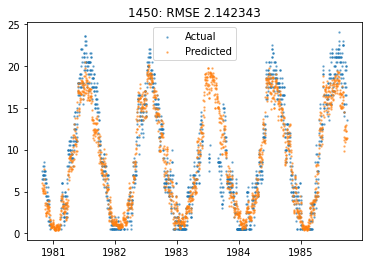

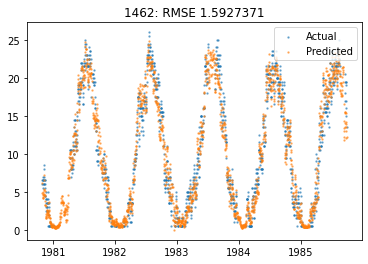

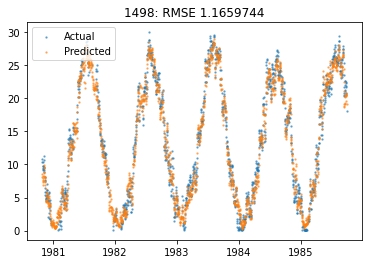

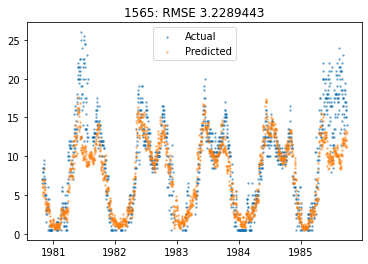

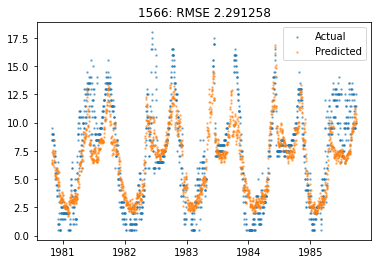

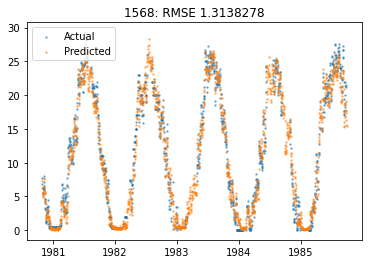

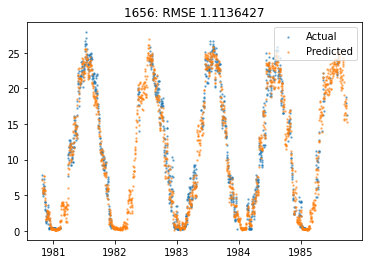

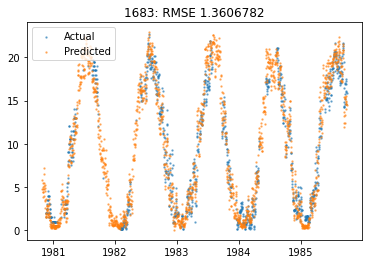

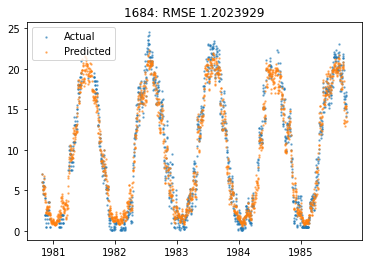

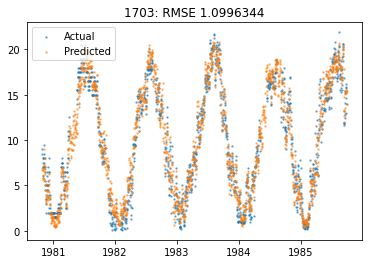

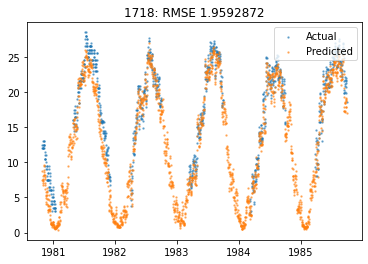

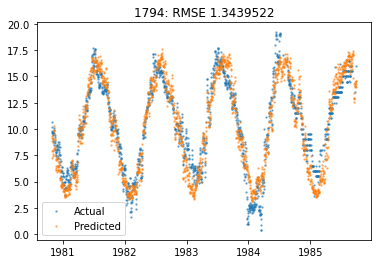

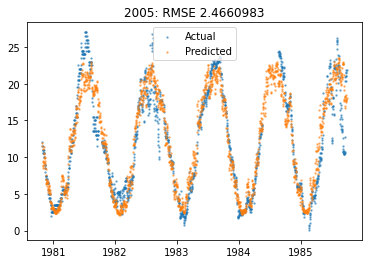

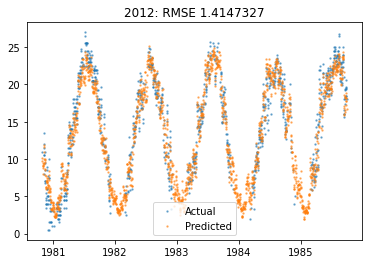

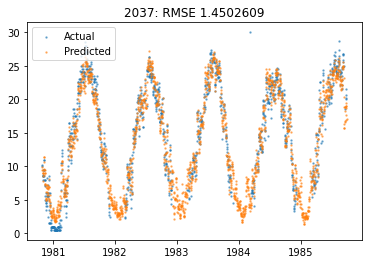

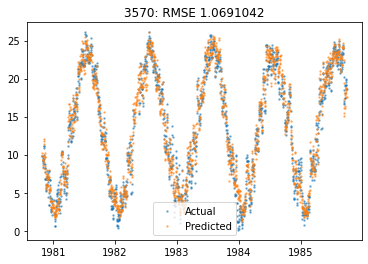

In [4]:
%matplotlib inline


data = np.load(args.data + '/data.npz')
period = data['period'][0]

test_dates =  np.transpose(data['dates_test'],(0,3,2,1)).squeeze()
test_ids =  np.transpose(data['ids_test'],(0,3,2,1)).squeeze()

if ~np.isnan(period):
    test_ids = test_ids[:,:,-period:]
    test_dates = test_dates[:,:,-period:]


def prepped_array_to_df(data_array, obs, dates, ids):

    df_obs = pd.DataFrame(obs.flatten(), columns = ['temp_ob'])
    df_preds = pd.DataFrame(data_array.flatten(), columns=['temp_pred'])
    df_dates = pd.DataFrame(dates.flatten(), columns=["date"])
    df_ids = pd.DataFrame(ids.flatten(), columns=["seg_id_nat"])
    df = pd.concat([df_dates, df_ids, df_preds, df_obs], axis=1)
    return df

test_df = prepped_array_to_df(np.array(yhat), np.array(realy), test_dates, test_ids)
test_df.to_csv(args.data+'/test_results')


counts = test_df.dropna().groupby('seg_id_nat').size()
filt = counts[counts > 1000].index.tolist()
test_df_filt = test_df[test_df.seg_id_nat.isin(filt)]


def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


def plotter(df,seg):
    df = df[df.seg_id_nat == seg]
    actual = df.temp_ob
    predicted = df.temp_pred
    fig, ax = plt.subplots()
    x = df.date
    ax.scatter(x, actual, s=2, alpha = .5, label='Actual')
    ax.scatter(x, predicted,s=2, alpha=.5, label='Predicted')
    rms = rmse(actual, predicted)
    ax.legend()
    ax.set_title(str(seg) + ': RMSE ' + str(rms))

for i in filt:
    plotter(test_df_filt,i)

/home/stopp/.conda/envs/gwn/lib/python3.7/site-packages/numpy/lib/histograms.py:403: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
/home/stopp/.conda/envs/gwn/lib/python3.7/site-packages/numpy/lib/histograms.py:404: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
/home/stopp/.conda/envs/gwn/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/stopp/.conda/envs/gwn/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


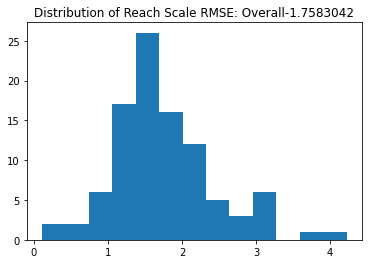

In [16]:
overall = rmse(test_df.temp_ob,test_df.temp_pred)

rmses = []
for i in np.unique(test_df.seg_id_nat):
    df = test_df[test_df.seg_id_nat == i]
    rmse_seg = rmse(df.temp_ob,df.temp_pred)
    rmses.append(rmse_seg)
    
_ = plt.hist(rmses, bins='auto')  # arguments are passed to np.histogram
plt.title("Distribution of Reach Scale RMSE: Overall-"+str(overall))
#Text(0.5, 1.0, "Histogram with 'auto' bins")
plt.show()

In [17]:
i = filt[0]
df = test_df[test_df.seg_id_nat == i]
print(df)
rmse_seg = rmse(df.temp_ob, df.temp_pred)
print(rmse_seg)

             date  seg_id_nat  temp_pred  temp_ob
45     1980-10-28        1450   6.009490      7.5
46     1980-10-29        1450   5.379750      6.5
47     1980-10-30        1450   5.023431      6.5
1413   1980-11-27        1450   3.042331      3.5
1414   1980-11-28        1450   3.508421      4.0
...           ...         ...        ...      ...
816742 1985-08-01        1450  16.768778     18.0
816743 1985-08-02        1450  17.130547     18.5
818109 1985-08-30        1450  15.534492     19.0
818110 1985-08-31        1450  14.928663     17.5
818111 1985-09-01        1450  15.225901     17.5

[1797 rows x 4 columns]
2.142343
